In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt

2024-03-25 12:01:14.701655: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def unet_model(input_shape):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(drop5)
    up6 = concatenate([up6, drop4], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv3], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

input_shape = (256, 256, 3)  # Taille d'entrée de l'image
model = unet_model(input_shape)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_9[0][0]  

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
def load_data(data_dir):
    images = []
    masks = []
    data_path = ''
    dt_tab = []
    for filename in os.listdir(data_dir):
        if filename != '.DS_Store':
            if data_dir == 'images/':
                data_path = os.path.join(data_dir, filename)
                image = img_to_array(Image.open(data_path).convert('RGB').resize(input_shape[:2]))
                dt_tab.append(image)
            elif data_dir == 'masks/':
                data_path = os.path.join(data_dir, filename)
                mask = img_to_array(Image.open(data_path).convert('L').resize(input_shape[:2]))
                mask = np.expand_dims(mask, axis=-1)
                dt_tab.append(mask)
            elif data_dir == 'images_val/':
                data_path = os.path.join(data_dir, filename)
                image = img_to_array(Image.open(data_path).convert('RGB').resize(input_shape[:2]))
                dt_tab.append(image)
            elif data_dir == 'masks_val/':
                data_path = os.path.join(data_dir, filename)
                mask = img_to_array(Image.open(data_path).convert('L').resize(input_shape[:2]))
                mask = np.expand_dims(mask, axis=-1)
                dt_tab.append(mask)
    return np.array(dt_tab)

images = load_data('images/')
masks = load_data('masks/')
images_val = load_data('images_val/')
masks_val = load_data('masks_val/')
print("Nombre total d'images chargées:", len(images))
print("Nombre total de masks chargées:", len(masks))
print("Nombre total d'images val chargées:", len(images_val))
print("Nombre total de masks val chargées:", len(masks_val))

Nombre total d'images chargées: 174
Nombre total de masks chargées: 174
Nombre total d'images val chargées: 36
Nombre total de masks val chargées: 36


In [7]:
# Normalisation des données
X_train = images / 255.0
X_val = images_val / 255.0
y_train = masks / 255.0
y_val = masks_val / 255.0

# Définition du modèle
input_shape = (256, 256, 3)
model = unet_model(input_shape)

# Compilation du modèle
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

# Entraînement du modèle
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=5, verbose=1)

Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 421s 66s/step - accuracy: 0.9338 - loss: 0.7158 - val_accuracy: 0.9191 - val_loss: 0.3629
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 390s 64s/step - accuracy: 0.9264 - loss: 0.3973 - val_accuracy: 0.9191 - val_loss: 1.6964
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 377s 62s/step - accuracy: 0.9248 - loss: 1.0742 - val_accuracy: 0.9191 - val_loss: 0.2864
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 354s 58s/step - accuracy: 0.9278 - loss: 0.2879 - val_accuracy: 0.9191 - val_loss: 0.3002
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 366s 60s/step - accuracy: 0.9214 - loss: 0.2740 - val_accuracy: 0.9191 - val_loss: 0.3219


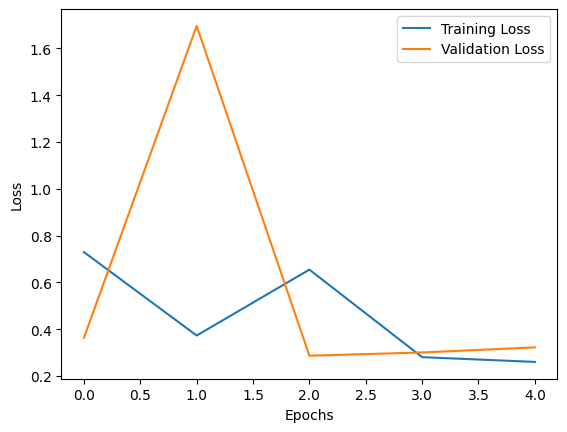

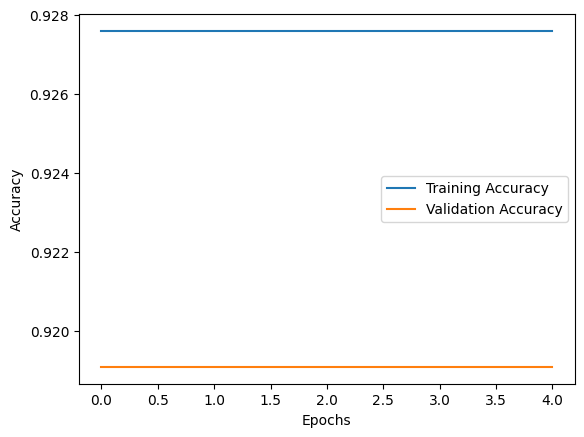

In [8]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [9]:
from tensorflow.keras.models import save_model

save_model(model, 'model_01.h5')

In [10]:
from tensorflow.keras.models import load_model

model = load_model('./models/model_01.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


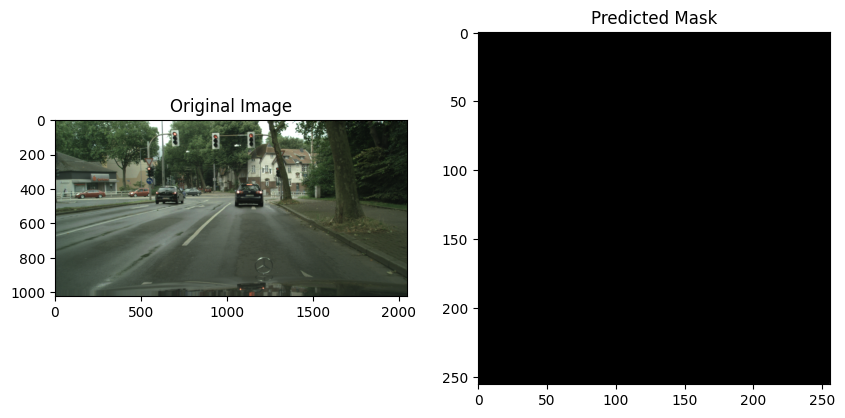

In [13]:
def predict_image(model, image_path):
    image = img_to_array(Image.open(image_path).convert('RGB').resize(input_shape[:2]))
    image = np.expand_dims(image, axis=0)
    mask = model.predict(image)
    return mask[0]

# Exemple d'utilisation du modèle pour prédire une image
image_path = '../../Data/files/Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/bochum/bochum_000000_000600_leftImg8bit.png'
predicted_mask = predict_image(model, image_path)

# Visualisation de l'image d'origine et de sa prédiction de masque
img = Image.open(image_path)
#img = img_to_array(img.convert('RGB').resize(input_shape[:2]))
#img = Image.fromarray(img)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
#plt.imshow(Image.open(image_path))
plt.imshow(img)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask[:, :, 0], cmap='gray')
plt.title('Predicted Mask')

plt.show()